In [305]:
%load_ext autoreload
%autoreload 2

import boto3
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sys

from run_utils import compute_across_trials_s3, plot_ratings_mses_s3
from run_utils import get_env_dataset

sys.path.append('../') 
from reclab.environments import LatentFactorBehavior 
from env_defaults import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
matplotlib.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')

bigfont = 18
medfont = 14
smallfont = 12
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set_palette("muted")

In [307]:
bucket_name = 'recsys-eval'
bucket = boto3.resource('s3').Bucket(bucket_name)
data_dir = 'Sarah'

# Plots for topics_static_lowdata

In [337]:
full_recommender_names = ['LibFM (SGD)', 
                          'LibFM (SGD) thompson,20','LibFM (SGD) thompson', 
                          'LibFM (SGD) eps_greedy', 'LibFM (SGD) eps_greedy,0.2', 
                          'LibFM (MCMC)',
                          'LibFM (MCMC) thompson,20','LibFM (MCMC) thompson',
                          'LibFM (MCMC) eps_greedy', 'LibFM (MCMC) eps_greedy,0.2',] 

labels = ['SGD MF','SGD MF 20-Thompson','SGD MF 8-Thompson', 
           'SGD MF 0.1-greedy', 'SGD MF 0.2-greedy', 
                          'Bayesian MF',
                           'Bayesian MF 20-Thompson','Bayesian MF 8-Thompson',
          'Bayesian MF 0.1-greedy', 'Bayesian MF 0.2-greedy',] 



/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


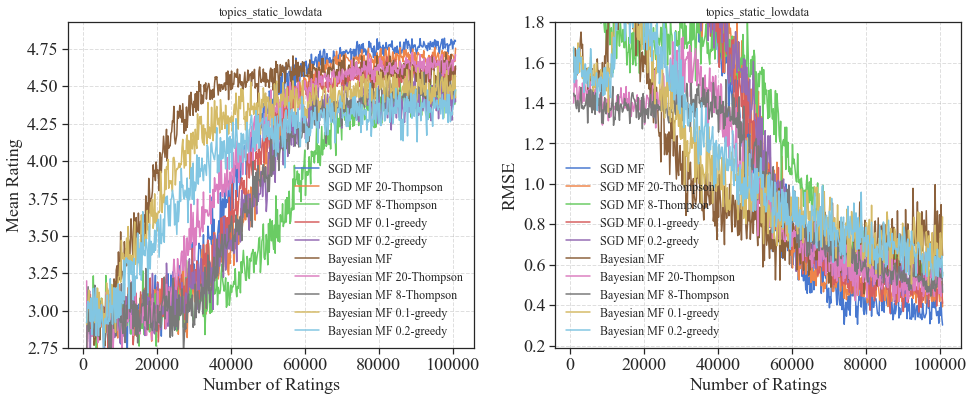

In [338]:
ENV_PARAMS = TOPICS_STATIC
env_name = ENV_PARAMS['name'] + '_lowdata'

# Experiment setup.
n_trials = 1
trial_seeds = [i for i in range(n_trials)]
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings'] - 99000
len_trial = get_len_trial(ENV_PARAMS)
num_users, _ = get_num_users_items(ENV_PARAMS)


all_stats = plot_ratings_mses_s3(full_recommender_names,
                                 labels,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10,
                     title=[env_name, env_name])

#TODO! this just takes a long time to run locally
all_stats_dense = all_stats
# plot_ratings_mses_s3(full_recommender_names,
#                      len_trial,
#                      bucket_name,
#                      data_dir,
#                      env_name,
#                      trial_seeds,
#                      plot_dense=True,
#                      num_users=num_users,
#                      num_init_ratings=num_init_ratings,
#                      rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
#                      threshold=10,
#                      title=[env_name, env_name])

In [339]:
cutoff = int(1000 / (ENV_PARAMS['optional_params']['rating_frequency'] * num_users)) # 1000 ratings
all_means = {}
all_means_spread = {}
all_rmses = {}
all_rmses_spread = {}
for label in all_stats.keys():
    means, lower_bounds, upper_bounds = all_stats[label]
    means = means[0]
    lower_bounds = lower_bounds[0]
    upper_bounds = upper_bounds[0]
    
    all_means[label] = (np.mean(means[:cutoff]), np.mean(means[-cutoff:]))
    all_means_spread[label] = (np.mean(lower_bounds[:cutoff]-upper_bounds[:cutoff]),
                               np.mean(lower_bounds[-cutoff:]-upper_bounds[-cutoff:]))
    
    means, lower_bounds, upper_bounds = all_stats[label]
    mse = means[1]
    lower_bounds = lower_bounds[1]
    upper_bounds = upper_bounds[1]
    # Transform the MSE into the RMSE and correct the associated intervals.
    rmse = np.sqrt(mse)
    lower_bounds = np.sqrt(lower_bounds)
    upper_bounds = np.sqrt(upper_bounds)
        
    all_rmses[label] = (np.mean(rmse[:cutoff]), np.mean(rmse[-cutoff:]))
    all_rmses_spread[label] = (np.mean(lower_bounds[:cutoff]-upper_bounds[:cutoff]),
                               np.mean(lower_bounds[-cutoff:]-upper_bounds[-cutoff:]))

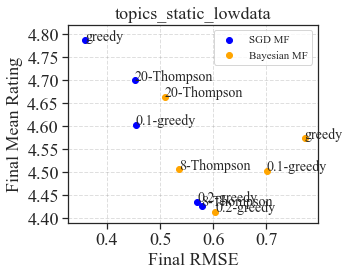

In [340]:
base_fig_height = 4
base_fig_width = 5

plt.figure(figsize=(base_fig_width,base_fig_height))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
# rmses = [all_rmses[label][1] - all_rmses[label][0] for label in labels]
# means = [all_means[label][1] - all_means[label][0] for label in labels]

rmses = [all_rmses[label][1] for label in labels  if 'SGD' in label ]
means = [all_means[label][1] for label in labels if 'SGD' in label ]

plt.scatter(rmses, 
             means, c='blue', label='SGD MF')

rmses = [all_rmses[label][1] for label in labels if 'Bayes' in label ]
means = [all_means[label][1] for label in labels if 'Bayes' in label]

plt.scatter(rmses, 
             means, c='orange', label='Bayesian MF')
plt.legend()
#              xerr=ndcgs_std * 2, yerr=np.array(stds) * 2, 
#              linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("Final RMSE", fontsize=bigfont)
plt.ylabel("Final Mean Rating", fontsize=bigfont)
# plt.xlim(right=2.2)
# plt.ylim(top=5.0)

rmses = [all_rmses[label][1] for label in labels]
means = [all_means[label][1] for label in labels]

for i, rec_name in enumerate(labels):
    rec_name = rec_name.split(' ')[2] if len(rec_name.split()) > 2 else 'greedy'
    plt.annotate(rec_name, (rmses[i] , means[i]), fontsize=medfont)
plt.title('topics_static_lowdata', fontsize=bigfont)
plt.tight_layout()
plt.savefig('topics-static-exploration-scatter.pdf', bbox_inches='tight')

In [341]:
#TODO!
dense_rmses = all_rmses
dense_rmses_spread = all_rmses_spread

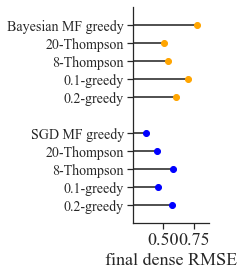

In [342]:
labels = all_stats.keys()

# width=0.8
# num_sgd = 5; num_mcms = 4


plt.figure(figsize=[0.19*base_fig_width/0.3,base_fig_height])

ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)


label_ticks = [label.split(' ')[2]  if len(label.split()) > 2 else '{} greedy'.format(label) for label in labels]
N = len(label_ticks)
ticks1 = list(reversed(np.arange(N//2))) 
ticks2 = list(reversed(np.arange(N//2+1, N+1)))
ticks = ticks1 + ticks2

heights1 = [dense_rmses[label][1] for label in labels if 'SGD' in label]
heights2 = [dense_rmses[label][1] for label in labels if 'Bayesian' in label]
heights = heights1 + heights2

plt.hlines(y=ticks,xmin=0,xmax=heights)


plt.plot(heights1, ticks1, "o", color='blue', label='SGD MF')
plt.plot(heights2, ticks2, "o", color='orange', label='Bayesian MF')



plt.yticks(ticks, label_ticks)
plt.xlabel('final dense RMSE', fontsize=bigfont)
extent = [np.min(heights), np.max(heights)]
xrange = [extent[0] - 0.25*np.diff(extent), extent[1] + 0.25*np.diff(extent)]
plt.xlim(xrange); plt.ylim([-1, max(ticks)+1])
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=medfont)

plt.tight_layout()
plt.savefig('topics-static-exploration-dense.pdf', bbox_inches='tight')

/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


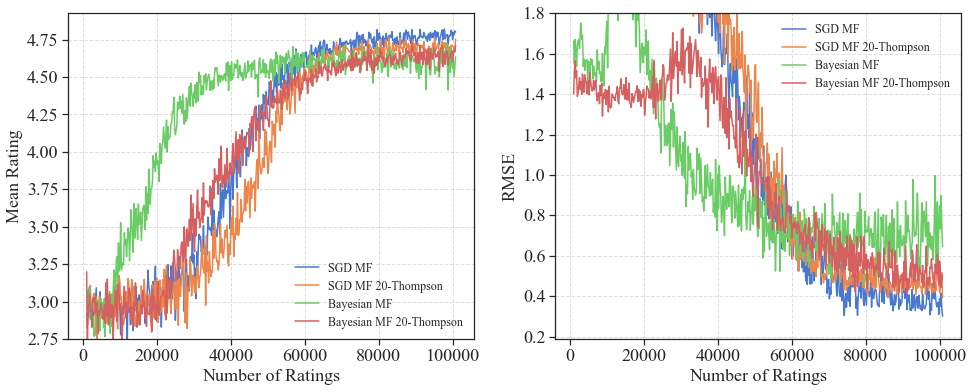

In [343]:
recommender_names = ['LibFM (SGD)', 
                     'LibFM (SGD) thompson,20',
#                      'LibFM (SGD) eps_greedy',
                     'LibFM (MCMC)', 
                     'LibFM (MCMC) thompson,20']
#                      'LibFM (MCMC) eps_greedy',] 

labels = ['SGD MF','SGD MF 20-Thompson',
#           'SGD MF 0.1-greedy',
          'Bayesian MF','Bayesian MF 20-Thompson']
#           'Bayesian MF 0.1-greedy']


all_stats = plot_ratings_mses_s3(recommender_names,
                     labels,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10);

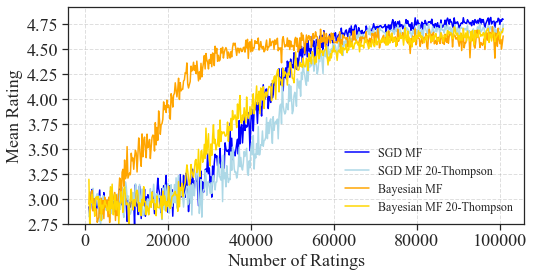

In [344]:
rgblist = ['blue', 'lightblue', 'orange', 'gold'] # sns.color_palette(n_colors=len(labels))
x_vals = num_init_ratings + num_users * ENV_PARAMS['optional_params']['rating_frequency'] * np.arange(len_trial)

plt.figure(figsize=[0.49*base_fig_width/0.3,base_fig_height])
plt.subplot(1, 1, 1)
for label, rgb in zip(labels, rgblist):
    means, lower_bounds, upper_bounds = all_stats[label]
    means = means[0]
    lower_bounds = lower_bounds[0]
    upper_bounds = upper_bounds[0]
    plt.plot(x_vals, means, label=label, color=rgb)
    plt.fill_between(x_vals, lower_bounds, upper_bounds, alpha=0.25, color=rgb)
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.xlabel('Number of Ratings', fontsize=bigfont)
plt.ylabel('Mean Rating', fontsize=bigfont)
plt.ylim(bottom=2.75)
plt.legend(fontsize=smallfont, markerscale=1, framealpha=1, frameon=False)
plt.savefig('topics-static-exploration-timeseries.pdf', bbox_inches='tight')

# Plot for latent_static_lowdata

In [328]:
full_recommender_names = ['LibFM (SGD)', 
                          'LibFM (SGD) thompson,20','LibFM (SGD) thompson', 
                          'LibFM (SGD) eps_greedy', 'LibFM (SGD) eps_greedy,0.2', 
                          'LibFM (MCMC)',
#                           'LibFM (MCMC) thompson,20',
                          'LibFM (MCMC) thompson',
                          'LibFM (MCMC) eps_greedy', ]
#                           'LibFM (MCMC) eps_greedy,0.2',] 


labels = ['SGD MF',
          'SGD MF 20-Thompson','SGD MF 8-Thompson', 
           'SGD MF 0.1-greedy', 'SGD MF 0.2-greedy', 
                          'Bayesian MF',
#                            'Bayesian MF 20-Thompson',
          'Bayesian MF 8-Thompson',
          'Bayesian MF 0.1-greedy',]
#           'Bayesian MF 0.2-greedy',] 



/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


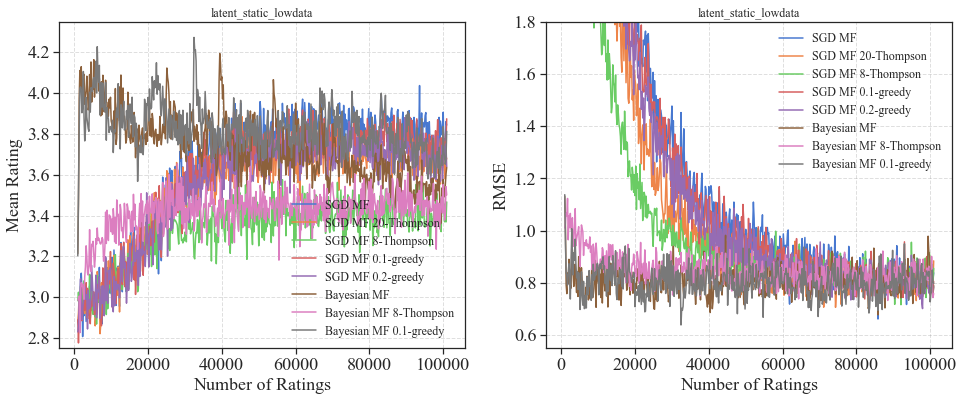

In [329]:
ENV_PARAMS = LATENT_STATIC
env_name = ENV_PARAMS['name'] + '_lowdata'

# Experiment setup.
n_trials = 1
trial_seeds = [i for i in range(n_trials)]
num_init_ratings = ENV_PARAMS['optional_params']['num_init_ratings'] - 99000
len_trial = get_len_trial(ENV_PARAMS)
num_users, _ = get_num_users_items(ENV_PARAMS)


all_stats = plot_ratings_mses_s3(full_recommender_names,
                                 labels,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10,
                     title=[env_name, env_name])

#TODO! this just takes a long time to run locally
all_stats_dense = all_stats
# plot_ratings_mses_s3(full_recommender_names,
#                      len_trial,
#                      bucket_name,
#                      data_dir,
#                      env_name,
#                      trial_seeds,
#                      plot_dense=True,
#                      num_users=num_users,
#                      num_init_ratings=num_init_ratings,
#                      rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
#                      threshold=10,
#                      title=[env_name, env_name])

In [330]:
cutoff = int(1000 / (ENV_PARAMS['optional_params']['rating_frequency'] * num_users)) # 1000 ratings
all_means = {}
all_means_spread = {}
all_rmses = {}
all_rmses_spread = {}
for label in all_stats.keys():
    means, lower_bounds, upper_bounds = all_stats[label]
    means = means[0]
    lower_bounds = lower_bounds[0]
    upper_bounds = upper_bounds[0]
    
    all_means[label] = (np.mean(means[:cutoff]), np.mean(means[-cutoff:]))
    all_means_spread[label] = (np.mean(lower_bounds[:cutoff]-upper_bounds[:cutoff]),
                               np.mean(lower_bounds[-cutoff:]-upper_bounds[-cutoff:]))
    
    means, lower_bounds, upper_bounds = all_stats[label]
    mse = means[1]
    lower_bounds = lower_bounds[1]
    upper_bounds = upper_bounds[1]
    # Transform the MSE into the RMSE and correct the associated intervals.
    rmse = np.sqrt(mse)
    lower_bounds = np.sqrt(lower_bounds)
    upper_bounds = np.sqrt(upper_bounds)
        
    all_rmses[label] = (np.mean(rmse[:cutoff]), np.mean(rmse[-cutoff:]))
    all_rmses_spread[label] = (np.mean(lower_bounds[:cutoff]-upper_bounds[:cutoff]),
                               np.mean(lower_bounds[-cutoff:]-upper_bounds[-cutoff:]))

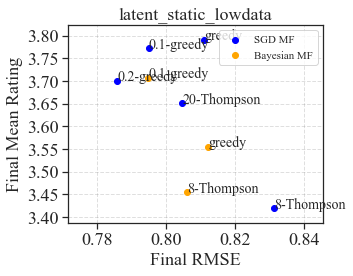

In [331]:
plt.figure(figsize=(base_fig_width,base_fig_height))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
# rmses = [all_rmses[label][1] - all_rmses[label][0] for label in labels]
# means = [all_means[label][1] - all_means[label][0] for label in labels]

rmses = [all_rmses[label][1] for label in labels  if 'SGD' in label ]
means = [all_means[label][1] for label in labels if 'SGD' in label ]

plt.scatter(rmses, 
             means, c='blue', label='SGD MF')

rmses = [all_rmses[label][1] for label in labels if 'Bayes' in label ]
means = [all_means[label][1] for label in labels if 'Bayes' in label]

plt.scatter(rmses, 
             means, c='orange', label='Bayesian MF')
plt.legend()
#              xerr=ndcgs_std * 2, yerr=np.array(stds) * 2, 
#              linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("Final RMSE", fontsize=bigfont)
plt.ylabel("Final Mean Rating", fontsize=bigfont)
# plt.xlim(right=2.2)
# plt.ylim(top=5.0)

rmses = [all_rmses[label][1] for label in labels]
means = [all_means[label][1] for label in labels]

for i, rec_name in enumerate(labels):
    rec_name = rec_name.split(' ')[2] if len(rec_name.split()) > 2 else 'greedy'
    plt.annotate(rec_name, (rmses[i] , means[i]), fontsize=medfont)
plt.title('latent_static_lowdata', fontsize=bigfont)
plt.tight_layout()
plt.savefig('latent-static-exploration-scatter.pdf', bbox_inches='tight')

In [303]:
#TODO!
dense_rmses = all_rmses
dense_rmses_spread = all_rmses_spread

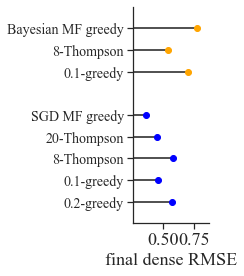

In [332]:
labels = all_stats.keys()

# width=0.8
# num_sgd = 5; num_mcms = 4


plt.figure(figsize=[0.19*base_fig_width/0.3,base_fig_height])

ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)


label_ticks = [label.split(' ')[2]  if len(label.split()) > 2 else '{} greedy'.format(label) for label in labels]
N = len(label_ticks)
# ticks1 = list(reversed(np.arange(N//2))) 
ticks1 = list(reversed(np.arange(5))) 
# ticks2 = list(reversed(np.arange(N//2+1, N+1)))
ticks2 = list(reversed(np.arange(6, 9)))
ticks = ticks1 + ticks2

heights1 = [dense_rmses[label][1] for label in labels if 'SGD' in label]
heights2 = [dense_rmses[label][1] for label in labels if 'Bayesian' in label]
heights = heights1 + heights2

plt.hlines(y=ticks,xmin=0,xmax=heights)


plt.plot(heights1, ticks1, "o", color='blue', label='SGD MF')
plt.plot(heights2, ticks2, "o", color='orange', label='Bayesian MF')



plt.yticks(ticks, label_ticks)
plt.xlabel('final dense RMSE', fontsize=bigfont)
extent = [np.min(heights), np.max(heights)]
xrange = [extent[0] - 0.25*np.diff(extent), extent[1] + 0.25*np.diff(extent)]
plt.xlim(xrange); plt.ylim([-1, max(ticks)+1])
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=medfont)

plt.tight_layout()
plt.savefig('latent-static-exploration-dense.pdf', bbox_inches='tight')

/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sarah/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


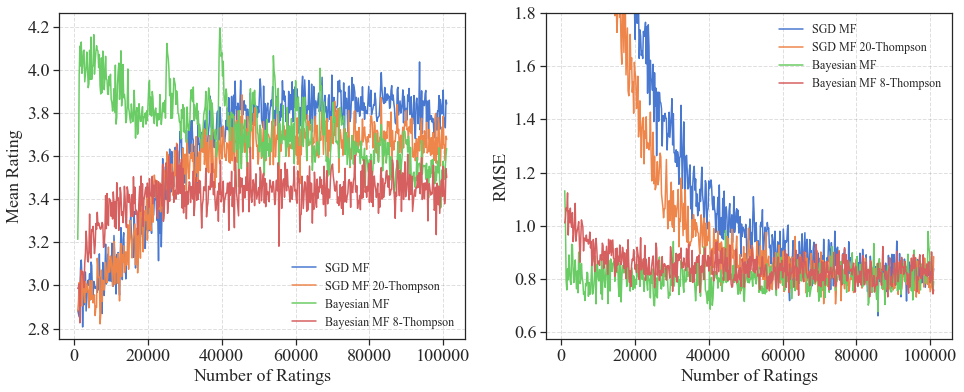

In [333]:
recommender_names = ['LibFM (SGD)', 
                     'LibFM (SGD) thompson,20',
#                      'LibFM (SGD) eps_greedy',
                     'LibFM (MCMC)', 
                     'LibFM (MCMC) thompson']
#                      'LibFM (MCMC) eps_greedy',] 

labels = ['SGD MF','SGD MF 20-Thompson',
#           'SGD MF 0.1-greedy',
          'Bayesian MF','Bayesian MF 8-Thompson']
#           'Bayesian MF 0.1-greedy']


all_stats = plot_ratings_mses_s3(recommender_names,
                     labels,
                     len_trial,
                     bucket_name,
                     data_dir,
                     env_name,
                     trial_seeds,
                     plot_dense=False,
                     num_users=num_users,
                     num_init_ratings=num_init_ratings,
                     rating_frequency = ENV_PARAMS['optional_params']['rating_frequency'],
                     threshold=10);

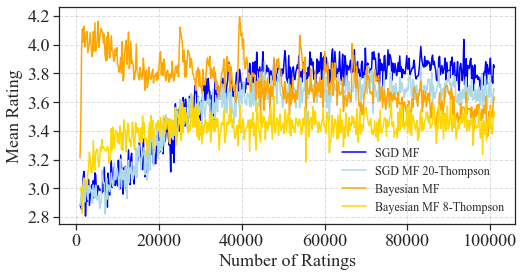

In [336]:
rgblist = ['blue', 'lightblue', 'orange', 'gold'] # sns.color_palette(n_colors=len(labels))
x_vals = num_init_ratings + num_users * ENV_PARAMS['optional_params']['rating_frequency'] * np.arange(len_trial)

plt.figure(figsize=[0.49*base_fig_width/0.3,base_fig_height])
plt.subplot(1, 1, 1)
for label, rgb in zip(labels, rgblist):
    means, lower_bounds, upper_bounds = all_stats[label]
    means = means[0]
    lower_bounds = lower_bounds[0]
    upper_bounds = upper_bounds[0]
    plt.plot(x_vals, means, label=label, color=rgb)
    plt.fill_between(x_vals, lower_bounds, upper_bounds, alpha=0.25, color=rgb)
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.xlabel('Number of Ratings', fontsize=bigfont)
plt.ylabel('Mean Rating', fontsize=bigfont)
plt.ylim(bottom=2.75)
plt.legend(fontsize=smallfont, markerscale=1, framealpha=1, frameon=False)
plt.savefig('latent-static-exploration-timeseries.pdf', bbox_inches='tight')